# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
import folium
import matplotlib.pyplot as plt

### Load the Europe Unemployment Data

In [35]:
ue_df = pd.read_csv('lfsq_urgan_1_Data.csv', header = 0)

# keep only 2017Q2 rate (the newest one)
# keep only TOTAL (exclude sex)
# KEEP only GEO and VALUE information
# delete the staticts for European union as a whole (first 6)
ue_df = ue_df[ue_df['TIME'] == '2017Q2' ][ue_df['SEX'] == 'Total' ][['GEO', 'Value']][6:]

ue_df.head()

/Users/patryk/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,GEO,Value
1071,Belgium,7.0
1074,Bulgaria,6.3
1077,Czech Republic,3.0
1080,Denmark,5.5
1083,Germany (until 1990 former territory of the FRG),3.8


### Clean the data
- Add ISO2 country codes 
- Add missing country codes as Nan values (needed for the map)

In [36]:
# adding ISO2 country codes 
ue_df['COUNTRY_CODE'] = ['BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'GR', 'ES', 'FR', 'HR', 'IT', 'CY', 'LV', 'LT', 'LU', 'HU', 'MT', 'NL', 'AT', 'PL', 'PT' , 'RO', 'SI', 'SK', 'FI', 'SE', 'GB', 'IS', 'NO', 'CH', 'MK', 'TR']

# now we need to add missing country codes 
values_undefined = ['AZ','AL','AM','BA','GE','IL','BY','LI','FO','AD','MC','ME','MD','UA','SM','RS','VA','RU']
for name_val in values_undefined:
    ue_df = ue_df.append( {'GEO':name_val, 'Value': np.NaN, 'COUNTRY_CODE':name_val}, ignore_index = True)

ue_df.head()

,GEO,Value,COUNTRY_CODE
0,Belgium,7.0,BE
1,Bulgaria,6.3,BG
2,Czech Republic,3.0,CZ
3,Denmark,5.5,DK
4,Germany (until 1990 former territory of the FRG),3.8,DE


### Exploratory Data Analysis

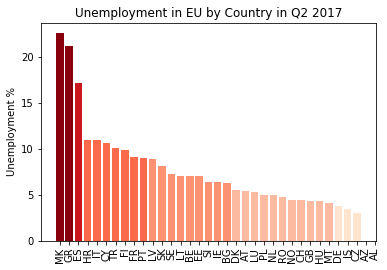

In [135]:
sorted_df = ue_df.copy()#pd.DataFrame( ue_df['Values','COUNTRY_CODE'] );
sorted_df.sort_values(['Value'], ascending = False, inplace=True)

colors_eu = ['#ffe5d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [4.0      , 6.0      , 9.0      , 13.0     , 16.0     , 19.0     , 21.0     , 24, 25]

def unemployment_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    val = sorted_df[sorted_df['COUNTRY_CODE'] == state]['Value']
    val = np.squeeze(val)
    if np.isnan(val):
        return '#bdbdbd'
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]

plt.figure(1)
sorted_df.sort_values(['Value'], ascending = False, inplace=True)
values = sorted_df['Value'].values
length = len(values)
names = sorted_df['COUNTRY_CODE'].values
plt.bar(range(0,length), values)
plt.xticks(range(0,length), names, rotation=90)
for i in range(0, length):
    nm = np.squeeze(sorted_df[sorted_df['COUNTRY_CODE'] == names[i]]['COUNTRY_CODE']);
    color = unemployment_colors_eu(nm)
    plt.bar(i,values[i], color=color)
plt.ylabel('Unemployment %')
plt.title('Unemployment in EU by Country in Q2 2017')
plt.show()  

### Show the choropleth Map

In [145]:
eur_path = os.path.join('', 'europe2.topojson.json')

topo_json_data = json.load(open(eur_path))
m = folium.Map(location=[56, 10], zoom_start=3.5)
folium.TopoJson(
    topo_json_data,
    object_path='objects.europe',
    style_function=lambda feature: {
        'fillColor': unemployment_colors_eu(feature['id']),
        'fillOpacity': 0.9,
        'line_opacity':0.3,
        'weight': 0.4,
        'legend_name':'Unemployment Rate (%)',  
        }
    ).add_to(m)

linear = folium.colormap.StepColormap( colors=colors_eu, vmin=4.0, vmax=21.0,  caption='Europe Unemployment in < %').add_to(m)
linear.index = thresh_eu
m

### tha same for Swiztrland

In [16]:
swiss_df = pd.read_excel('Arbeitslosen- und Jugendarbeitslosenquote nach verschiedenen Kriterien.xlsx',skiprows=3)
swiss_df.columns = ['Canton','Na','Unemployment rate', 'Unemployed people']
swiss_df = swiss_df[['Canton','Unemployment rate']]
swiss_df['CODE'] = ['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']     
swiss_df.head()

,Canton,Unemployment rate,CODE
0,Zürich,3.3,ZH
1,Bern,2.4,BE
2,Luzern,1.7,LU
3,Uri,0.6,UR
4,Schwyz,1.7,SZ


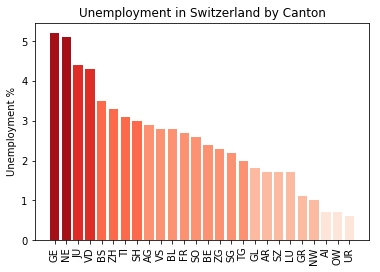

In [142]:
colors_swiss = ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']
thresh_swiss = [1.0      , 2.0      , 3.0      , 4.0      , 5.0      , 6.0     , 7, 8]

def unemployment_colors_swiss(state):
    """Maps Unemplpoyment value with colors."""
    val = swiss_df[swiss_df['CODE'] == state]['Unemployment rate']
    val = np.squeeze(val)
    length = len(colors_swiss)
    for i in range(0, length-1):
        if val < thresh_swiss[i]:
            return colors_swiss[i]
    return  colors_swiss[length-1]

plt.figure(1)
swiss_df.sort_values(['Unemployment rate'], ascending = False, inplace=True)
values = swiss_df['Unemployment rate'].values
length = len(values)
names = swiss_df['CODE'].values
plt.bar(range(0,length), values)
plt.bar(3,values[3], color='purple') # set CH to purple
plt.xticks(range(0,length), names, rotation=90)
for i in range(0, length):
    nm = np.squeeze(swiss_df[swiss_df['CODE'] == names[i]]['CODE']);
    color = unemployment_colors_swiss(nm)
    plt.bar(i,values[i], color=unemployment_colors_swiss(nm))
plt.ylabel('Unemployment %')
plt.title('Unemployment in Switzerland by Canton')
plt.show()

In [147]:
cantons_path = os.path.join('', 'ch-cantons_topo.json')

topo_json_data = json.load(open(cantons_path))
m = folium.Map(location=[46.7, 8], zoom_start=8)
folium.TopoJson(
    topo_json_data, 
    object_path='objects.cantons',
    style_function=lambda feature: {
        'fillColor': unemployment_colors_swiss(feature['id']),
        'fillOpacity': 0.9,
        'line_opacity':0.3,
        'weight': 0.4,
        'legend_name':'Unemployment Rate (%)',
        
        }
    ).add_to(m)

linear = folium.colormap.StepColormap( colors=colors_swiss, vmin=1.0, vmax=6.0,  caption='Swiss Unemployment in < %').add_to(m)
linear.index = thresh_swiss

m

---

Let's make this a bit more visual:

In [6]:
for i  in range(len(ue_df["INDIC"])):
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Total":
        ue_df["INDIC"][i] = "Total"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Males":
        ue_df["INDIC"][i] = "Male Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Females":
        ue_df["INDIC"][i] = "Female Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Over 25 years - Total":
        ue_df["INDIC"][i] = "25+ Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Over 25 years - Males":
        ue_df["INDIC"][i] = "25+ Male Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Over 25 years - Females":
        ue_df["INDIC"][i] = "25+ Female Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Under 25 years - Total":
        ue_df["INDIC"][i] = "25- Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Under 25 years - Males":
        ue_df["INDIC"][i] = "25- Male Population"
    if ue_df["INDIC"][i] ==  "Unemployment according to ILO definition - Under 25 years - Females":
        ue_df["INDIC"][i] = "25- Female Population"

ue_df.head()

,TIME,GEO,UNIT,S_ADJ,INDIC,Value,Flag and Footnotes
0,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",Percentage of active population,Unadjusted data (i.e. neither seasonally adjus...,Total,9.6,NaN
1,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",Percentage of active population,Unadjusted data (i.e. neither seasonally adjus...,Male Population,9.4,NaN
2,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",Percentage of active population,Unadjusted data (i.e. neither seasonally adjus...,Female Population,9.9,NaN
3,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",Percentage of active population,Unadjusted data (i.e. neither seasonally adjus...,25- Population,19.3,NaN
4,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",Percentage of active population,Unadjusted data (i.e. neither seasonally adjus...,25- Male Population,19.9,NaN


Clean data:

In [7]:
ue_temp = ue_df
del ue_temp["Flag and Footnotes"]


Since the UNIT is always the same for all entries, we can delete the column *UNIT*. We just have to note that the value is always in percentage of active population.

In [8]:
del ue_temp["UNIT"]

In [10]:
ue_temp = ue_temp[ue_temp["S_ADJ"]== "Seasonally adjusted data, not calendar adjusted data"]
ue_temp.head()

,TIME,GEO,S_ADJ,INDIC,Value
9,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...","Seasonally adjusted data, not calendar adjuste...",Total,9.6
10,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...","Seasonally adjusted data, not calendar adjuste...",Male Population,9.3
11,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...","Seasonally adjusted data, not calendar adjuste...",Female Population,10.0
12,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...","Seasonally adjusted data, not calendar adjuste...",25- Population,20.3
13,2016M12,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...","Seasonally adjusted data, not calendar adjuste...",25- Male Population,20.8


In [11]:
population = ue_temp[ue_temp["INDIC"]=="Total"]["Value"].values
male_population = ue_temp[ue_temp["INDIC"]=="Male Population"]["Value"].values
female_population = ue_temp[ue_temp["INDIC"]=="Female Population"]["Value"].values

under_population = ue_temp[ue_temp["INDIC"]=="25- Population"]["Value"].values
under_male_population = ue_temp[ue_temp["INDIC"]=="25- Male Population"]["Value"].values
under_female_population = ue_temp[ue_temp["INDIC"]=="25- Female Population"]["Value"].values

over_population = ue_temp[ue_temp["INDIC"]=="25+ Population"]["Value"].values
over_male_population = ue_temp[ue_temp["INDIC"]=="25+ Male Population"]["Value"].values
over_female_population = ue_temp[ue_temp["INDIC"]=="25+ Female Population"]["Value"].values


Now that we have stored our values in the above arrays, we can play a bit with our dataframe and make it more expressive.

In [12]:
countries = ue_temp["GEO"].values
countries
newcountries = []
for i in countries:
    if i not in newcountries:
        newcountries.append(i)
countries = newcountries*10

In [13]:
data = pd.DataFrame({'All the Population':population, 
                     'Male Population': male_population,
                     'Female Population': female_population,
                     'Population Under 25': under_population,
                     'Male Population Under 25': under_male_population,
                     'Female Population Under 25': under_female_population,
                     'Population Above 25': over_population,
                     'Male Population Above 25': over_male_population,
                     'Female Population Above 25': over_female_population,
                      'All Countries': countries })


In [14]:
data = data[data["All Countries"]!="Japan"]
data = data[data["All Countries"]!="United States"]
data.head()

,All Countries,All the Population,Female Population,Female Population Above 25,Female Population Under 25,Male Population,Male Population Above 25,Male Population Under 25,Population Above 25,Population Under 25
0,"Euro area (EA11-2000, EA12-2006, EA13-2007, EA...",9.6,10.0,9.1,19.8,9.3,8.2,20.8,8.6,20.3
1,Euro area (19 countries),9.6,10.0,9.1,19.8,9.3,8.2,20.8,8.6,20.3
2,Euro area (18 countries),9.7,10.0,9.1,19.9,9.3,8.2,20.8,8.6,20.4
3,European Union (28 countries),8.2,8.4,7.5,17.2,8.0,6.9,18.7,7.2,18.0
4,European Union (27 countries),8.1,8.3,7.5,17.1,8.0,6.9,18.6,7.1,17.9


In [14]:
mapsss=folium.Map(location=[54.5260, 15.2551],zoom_start=4,tiles="Mapbox Bright")
maps

NameError: name 'maps' is not defined

In [16]:
folium.TopoJson(open('topojson/europe.topojson.json'),
                'objects.topojson/europe.topojson',
               
                name='topojson',
               ).add_to(mapsss)
folium.LayerControl().add_to(mapsss)
mapsss

FileNotFoundError: [Errno 2] No such file or directory: 'topojson/europe.topojson.json'

In [52]:
mapsss

AttributeError: 'NoneType' object has no attribute 'get'

In [61]:

threshold_scale = np.linspace(float(data['All the Population'].min()),
                              float(data['All the Population'].max()), 6, dtype=int).tolist()


mapa = folium.Map(location=[-15.80, -47.88],
                  tiles="Mapbox Bright",
                  zoom_start=3)

mapa.topojson(geo_str=geo_str,
              data=df,
              columns=['state', '2013'],
              fill_color='YlGn',
              key_on='feature.id',
              threshold_scale=threshold_scale)

ValueError: could not convert string to float: ':'